<a href="https://colab.research.google.com/github/ShotaSasaki-HU/ASTRO-CAMP-2025/blob/main/sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリ

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt
import ee
from tqdm import tqdm # 進捗表示用
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install japanize-matplotlib
import japanize_matplotlib
import itertools
import pytz
from sklearn.metrics import mean_squared_error
import seaborn as sns
from pathlib import Path
!pip install rasterio
import rasterio
from rasterio.warp import reproject, Resampling


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=403001d228a84fa754ef00a96238d468a5338b82eb3ea510b3655542dd8b88aa
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 77.0 MB/s eta 0:00:00


# Google Driveのマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# データ準備

## 目的変数（誘殺数）

### 5年間の時系列化

In [3]:
all_years = []

for year in range(2020, 2024 + 1):
    # セジロウンカ
    path = (
        "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/"
        "main/data/%E9%A6%99%E5%B7%9D%E7%9C%8C%E8%BE%B2%E6%A5%AD%E8%A9%A6%"
        "E9%A8%93%E5%A0%B4%E7%97%85%E5%AE%B3%E8%99%AB%E9%98%B2%E9%99%A4%E6"
        "%89%80_%E6%A5%AD%E5%8B%99%E5%B9%B4%E5%A0%B1_%E5%90%84%E3%82%A4%E3"
        "%83%8D%E3%82%A6%E3%83%B3%E3%82%AB%E9%A1%9E%E3%81%AE%E6%97%A5%E5%8"
        "8%A5%E8%AA%98%E6%AE%BA%E6%95%B0/%E3%82%BB%E3%82%B8%E3%83%AD%E3%82"
        "%A6%E3%83%B3%E3%82%AB%E6%97%A5%E5%88%A5%E8%AA%98%E6%AE%BA%E6%95%B"
        f"0_{year}.csv"
    )
    df_year = pd.read_csv(path, encoding="utf-8", header=0)
    df_year.drop('Unnamed: 0', axis=1, inplace=True)

    # 「欠測」を0と見做す
    df_year.replace('欠測', 0, inplace=True)

    # メスとオスの和
    for month in range(4, 11 + 1):
        df_year[f'{month}月'] = df_year[f'{month}月_メス'].astype('float64') + df_year[f'{month}月_オス'].astype('float64') # NaNを扱うためにfloat
        df_year.drop([f'{month}月_メス', f'{month}月_オス'], axis=1, inplace=True)

    # 縦持ちへ変換
    df_year = df_year.melt(
        id_vars=['日'], # そのまま残る列
        value_vars=['4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月'], # 値となる列
        var_name='月', # 新しい列名
        value_name='kill_score'
        )

    # 「西向く侍」のNaN値を排除
    df_year.dropna(inplace=True)

    # '月'を数値化
    df_year['月'] = df_year['月'].str.replace('月', '').astype(int)

    # datetime生成
    df_year['date'] = pd.to_datetime({
        'year': year,
        'month': df_year['月'],
        'day': df_year['日'].astype(int)
    }, errors='raise')
    df_year = df_year.sort_values('date').reset_index(drop=True) # 時系列順にソート

    df_year = df_year[['date', 'kill_score']]
    all_years.append(df_year)

# 5年分を結合
df_resp = pd.concat(all_years, ignore_index=True)
df_resp['kill_score'] = df_resp['kill_score'].astype(int)

print(df_resp)


           date  kill_score
0    2020-04-01           0
1    2020-04-02           0
2    2020-04-03           0
3    2020-04-04           0
4    2020-04-05           0
...         ...         ...
1215 2024-11-26           0
1216 2024-11-27           0
1217 2024-11-28           0
1218 2024-11-29           0
1219 2024-11-30           0

[1220 rows x 2 columns]


### 月半旬（5日ごと）でグループ化
pandas.DataFrame.resampleを使う手もある．

In [4]:
df_resp['year'] = df_resp['date'].dt.year
df_resp['month'] = df_resp['date'].dt.month
df_resp['day'] = df_resp['date'].dt.day

df_resp['hanjun'] = pd.cut(
    df_resp['day'],
    bins=[0, 5, 10, 15, 20, 25, 31], # 区切り
    labels=[1, 6, 11, 16, 21, 26]    # 月半旬開始日
)

df_resp['hanjun_start'] = pd.to_datetime({
    'year': df_resp['year'],
    'month': df_resp['month'],
    'day': df_resp['hanjun']
}, errors='raise')
df_resp = df_resp.sort_values('hanjun_start').reset_index(drop=True) # 時系列順にソート

df_resp = df_resp.groupby(['hanjun_start'], as_index=False)['kill_score'].sum()

print(df_resp)


    hanjun_start  kill_score
0     2020-04-01           0
1     2020-04-06           0
2     2020-04-11           0
3     2020-04-16           0
4     2020-04-21           0
..           ...         ...
235   2024-11-06           0
236   2024-11-11           0
237   2024-11-16           0
238   2024-11-21           0
239   2024-11-26           0

[240 rows x 2 columns]


## 説明変数

### Google Earth Engineの認証

In [5]:
ee.Authenticate() # Colabではブラウザで認証を行う
ee.Initialize(project='astro-camp')
# ee.Initialize(project='my-project-astrocamp')


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


### １．積算温度（福建省）

#### CSV生成
CSVを作成済みの場合は，このセルをスキップする．

In [6]:
"""
aoi = ee.Geometry.Rectangle([118.64617, 25.00743, 118.76769, 25.10490])
developmental_zero = 12.0 # 発育下限温度（発育零点）
PERIOD_DAYS = 5

# 指定された期間の積算温度を計算する関数
def get_degree_days_for_period(start_date, end_date):
    ee_start_date = ee.Date(start_date.strftime('%Y-%m-%d'))
    ee_end_date = ee.Date(end_date.strftime('%Y-%m-%d'))
    days_in_period = ee_end_date.difference(ee_start_date, 'day')

    # 指定した月半旬のMODIS画像コレクションを取得
    collection = ee.ImageCollection('MODIS/061/MOD11A1').filterDate(ee_start_date, ee_end_date)

    # --- ここからが積算温度の計算部分 ---

    # 期間内の画像枚数をサーバーサイドでカウント
    image_count = collection.size()

    # 画像が1枚以上ある場合の関数
    def calculate_stats(img_collection):
        # 日々の積算温度を計算する関数
        def calculate_degree_days(image):
            # LSTバンドを選択し，スケール変換と単位変換（ケルビン -> 摂氏）．
            temp_celsius = image.select('LST_Day_1km').multiply(0.02).subtract(273.15)
            # (気温 - 基準温度) を計算．結果がマイナスなら0にする．
            degree_day = temp_celsius.subtract(developmental_zero).max(0)
            return degree_day

        # コレクション内の各画像（各日）に対して上記の関数を適用
        daily_degree_days = collection.map(calculate_degree_days)

        # 期間内の日平均積算温度を計算し、期間の日数を掛けて正規化
        total_degree_days_image = daily_degree_days.mean().multiply(days_in_period).rename('Degree_Days')

        # AOI内の平均値を計算
        stats = total_degree_days_image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=1000,
            maxPixels=1e9
        )
        return stats

    # 画像が0枚だった場合の関数
    def empty_case():
        return ee.Dictionary({'Degree_Days': None})

    # image_count > 0 の条件で分岐を実行
    # ee.Algorithms.If(condition, true_case, false_case)
    # greater than(0)
    stats = ee.Dictionary(ee.Algorithms.If(image_count.gt(0), calculate_stats(collection), empty_case()))

    return stats.getInfo().get('Degree_Days')

lagged_features = [] # 遅延した特徴量たち
dd_cache = {} # 計算結果を保存するキャッシュ用の辞書

for index, row in tqdm(df_resp.iterrows(), total=df_resp.shape[0], desc="積算温度を計算中"):
    current_start = row['hanjun_start']

    row_features = {} # 計算結果を格納する辞書
    row_features['hanjun_start'] = current_start

    # 1半旬前から3半旬前までをループ処理
    for lag in range(1, 3 + 1):
        start_lag = current_start - pd.Timedelta(days=PERIOD_DAYS * lag)
        end_lag = current_start - pd.Timedelta(days=PERIOD_DAYS * (lag - 1))

        # キャッシュキーを作成
        cache_key = start_lag.strftime('%Y-%m-%d')

        # キャッシュの確認
        if cache_key in dd_cache:
            # キャッシュがある場合
            dd_value = dd_cache[cache_key]
        else:
            # キャッシュが無い場合
            dd_value = get_degree_days_for_period(start_lag, end_lag)
            dd_cache[cache_key] = dd_value

        row_features[f'積算温度_{lag}半旬前'] = dd_value

    lagged_features.append(row_features)

# 計算結果のリストを新しいデータフレームに変換
df_degree_days = pd.DataFrame(lagged_features)

# NaN値の線形補間を実行（月半旬が短いためデータが無い場合あり）
df_degree_days.interpolate(method='linear', inplace=True)

aoi_info = aoi.getInfo()
coords = aoi_info['coordinates'][0]
min_lon = coords[0][0]
min_lat = coords[0][1]
max_lon = coords[2][0]
max_lat = coords[2][1]
file_name = f"df_degree_days_[{min_lon}, {min_lat}, {max_lon}, {max_lat}].csv"
df_degree_days.to_csv(file_name)

df_degree_days
"""


'\naoi = ee.Geometry.Rectangle([118.64617, 25.00743, 118.76769, 25.10490])\ndevelopmental_zero = 12.0 # 発育下限温度（発育零点）\nPERIOD_DAYS = 5\n\n# 指定された期間の積算温度を計算する関数\ndef get_degree_days_for_period(start_date, end_date):\n    ee_start_date = ee.Date(start_date.strftime(\'%Y-%m-%d\'))\n    ee_end_date = ee.Date(end_date.strftime(\'%Y-%m-%d\'))\n    days_in_period = ee_end_date.difference(ee_start_date, \'day\')\n\n    # 指定した月半旬のMODIS画像コレクションを取得\n    collection = ee.ImageCollection(\'MODIS/061/MOD11A1\').filterDate(ee_start_date, ee_end_date)\n\n    # --- ここからが積算温度の計算部分 ---\n\n    # 期間内の画像枚数をサーバーサイドでカウント\n    image_count = collection.size()\n\n    # 画像が1枚以上ある場合の関数\n    def calculate_stats(img_collection):\n        # 日々の積算温度を計算する関数\n        def calculate_degree_days(image):\n            # LSTバンドを選択し，スケール変換と単位変換（ケルビン -> 摂氏）．\n            temp_celsius = image.select(\'LST_Day_1km\').multiply(0.02).subtract(273.15)\n            # (気温 - 基準温度) を計算．結果がマイナスなら0にする．\n            degree_day = temp_celsius

#### CSV読み込み

In [12]:
path = "https://raw.githubusercontent.com/ShotaSasaki-HU/ASTRO-CAMP-2025/refs/heads/main/data/df_degree_days_%5B100%2C%2015%2C%20115%2C%2030%5D.csv"
df_degree_days = pd.read_csv(path, encoding="utf-8", header=0, index_col=0)
df_degree_days['hanjun_start'] = pd.to_datetime(df_degree_days['hanjun_start'], errors="raise")

df_degree_days


,hanjun_start,積算温度_1半旬前,積算温度_2半旬前,積算温度_3半旬前,積算温度_4半旬前,積算温度_5半旬前,積算温度_6半旬前,積算温度_7半旬前,積算温度_8半旬前,積算温度_9半旬前,積算温度_10半旬前,積算温度_11半旬前,積算温度_12半旬前
0,2020-04-01,86.550977,75.531730,66.304770,70.670952,72.113868,63.454232,64.226937,57.664229,36.176199,54.403571,47.461016,45.198907
1,2020-04-06,84.196312,86.550977,75.531730,66.304770,70.670952,72.113868,63.454232,64.226937,57.664229,36.176199,54.403571,47.461016
2,2020-04-11,68.900737,84.196312,86.550977,75.531730,66.304770,70.670952,72.113868,63.454232,64.226937,57.664229,36.176199,54.403571
3,2020-04-16,65.811132,68.900737,84.196312,86.550977,75.531730,66.304770,70.670952,72.113868,63.454232,64.226937,57.664229,36.176199
4,2020-04-21,85.812071,65.811132,68.900737,84.196312,86.550977,75.531730,66.304770,70.670952,72.113868,63.454232,64.226937,57.664229
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2024-11-06,48.702089,47.952729,49.192877,54.936876,63.386171,62.686080,60.383914,72.411434,62.919100,70.993597,67.492849,72.923486
236,2024-11-11,45.161967,48.702089,47.952729,49.192877,54.936876,63.386171,62.686080,60.383914,72.411434,62.919100,70.993597,67.492849
237,2024-11-16,53.456676,45.161967,48.702089,47.952729,49.192877,54.936876,63.386171,62.686080,60.383914,72.411434,62.919100,70.993597
238,2024-11-21,52.410584,53.456676,45.161967,48.702089,47.952729,49.192877,54.936876,63.386171,62.686080,60.383914,72.411434,62.919100


### ２．NDVI（福建省）

#### CSV生成
CSVを作成済みの場合は，このセルをスキップする．

In [9]:
"""
# 水田マスクの読み込み
def load_paddy_mask(paddy_path):
    with rasterio.open(paddy_path) as mask_src:
        mask_data = mask_src.read(1)
        transform = mask_src.transform
        crs = mask_src.crs
    return mask_data, transform, crs

# クリップされた福建省の画像から二期作の水田のNDVI・EVIを計算
# mean_ndvi: 画像内での平均
def get_vegetation_index_from_fujian_subset(parent_path, paddy_data, paddy_transform, paddy_crs):
    img_path = parent_path / "composite.tif"
    udm2_path = parent_path / "composite_udm2.tif"

    with rasterio.open(img_path) as src:
        profile = src.profile # 水田マスク作成に使用
        blue, green, red, nir = src.read([1, 2, 3, 4], out_dtype="float32")

    # NDVIとEVIを計算
    ndvi = (nir - red) / (nir + red + 1e-6) # 0除算対策あり
    evi = 2.5 * ((nir - red) / (nir + (6 * red) - (7.5 * blue) + 1 + 1e-6)) # 0除算対策あり

    # 雲マスク
    with rasterio.open(udm2_path) as udm2:
        clear_mask = udm2.read(1) # 真偽値
    ndvi = np.ma.masked_where(clear_mask != 1, ndvi) # マスク適用
    evi = np.ma.masked_where(clear_mask != 1, evi) # マスク適用

    # 水田マスク
    reprojected_mask = np.empty((profile["height"], profile["width"]), dtype=np.float32) # 衛星画像と同じサイズの配列を用意
    reproject(
        source=paddy_data,
        destination=reprojected_mask,
        src_transform=paddy_transform,
        src_crs=paddy_crs,
        dst_transform=profile["transform"],
        dst_crs=profile["crs"],
        dst_resolution=(profile["transform"][0], -profile["transform"][4]),
        resampling=Resampling.nearest, # 最近傍補間
    )
    # マスク適用（1が二期作の水田・0が非水田）
    ndvi = np.ma.masked_where(reprojected_mask != 1, ndvi)
    evi = np.ma.masked_where(reprojected_mask != 1, evi)

    return np.nanmean(ndvi), np.nanmean(evi)

root_directory_path = "/content/drive/MyDrive/アストロキャンプ/planet"
root_path = Path(root_directory_path) # Pathオブジェクトを作成

# '*/composite.tif' のパターンで、全ての該当ファイルを検索
tiff_files = sorted(root_path.glob('*/composite.tif'))

# 水田マスクのTIFF画像を一度だけ読み込み
paddy_path = (
        "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/"
        "data/classified-Fujian-2024-double_rice-v1.tif"
    )
paddy_data, paddy_transform, paddy_crs = load_paddy_mask(paddy_path)

ndvi_dict = {}
evi_dict = {}
for tiff_path in tqdm(tiff_files, desc="Processing NDVI"):
    folder_name = tiff_path.parent.name # 親フォルダの名前を取得
    date_string = folder_name.split('_')[0] # フォルダ名の日付部分を取得
    date_dt = dt.datetime.strptime(date_string, '%Y%m%d').date() # 日付文字列をdatetimeオブジェクトに変換
    ndvi_dict[date_dt], evi_dict[date_dt] = get_vegetation_index_from_fujian_subset(tiff_path.parent, paddy_data, paddy_transform, paddy_crs)

df_vi = pd.DataFrame({
    "date": pd.date_range(start="2020-01-01", end="2024-12-31", freq="D")
})
df_vi['ndvi'] = df_vi['date'].map(ndvi_dict)
df_vi['evi'] = df_vi['date'].map(evi_dict)

df_vi.to_csv("NDVI_EVI_2020-2024_raw.csv")
df_vi
"""


Processing NDVI: 100%|██████████| 326/326 [08:33<00:00,  1.57s/it]


,date,ndvi,evi
0,2020-01-01,NaN,NaN
1,2020-01-02,NaN,NaN
2,2020-01-03,NaN,NaN
3,2020-01-04,NaN,NaN
4,2020-01-05,NaN,NaN
...,...,...,...
1822,2024-12-27,NaN,NaN
1823,2024-12-28,NaN,NaN
1824,2024-12-29,NaN,NaN
1825,2024-12-30,NaN,NaN


#### CSV読み込み

In [30]:
path = "https://github.com/ShotaSasaki-HU/ASTRO-CAMP-2025/raw/refs/heads/main/data/NDVI_EVI_2020-2024_raw.csv"
df_vi = pd.read_csv(path, encoding="utf-8", header=0, index_col=0)
df_vi['date'] = pd.to_datetime(df_vi['date'], errors="raise")

df_vi


,date,ndvi,evi
0,2020-01-01,NaN,NaN
1,2020-01-02,NaN,NaN
2,2020-01-03,NaN,NaN
3,2020-01-04,NaN,NaN
4,2020-01-05,NaN,NaN
...,...,...,...
1822,2024-12-27,NaN,NaN
1823,2024-12-28,NaN,NaN
1824,2024-12-29,NaN,NaN
1825,2024-12-30,NaN,NaN


#### z-scoreによる外れ値の除去

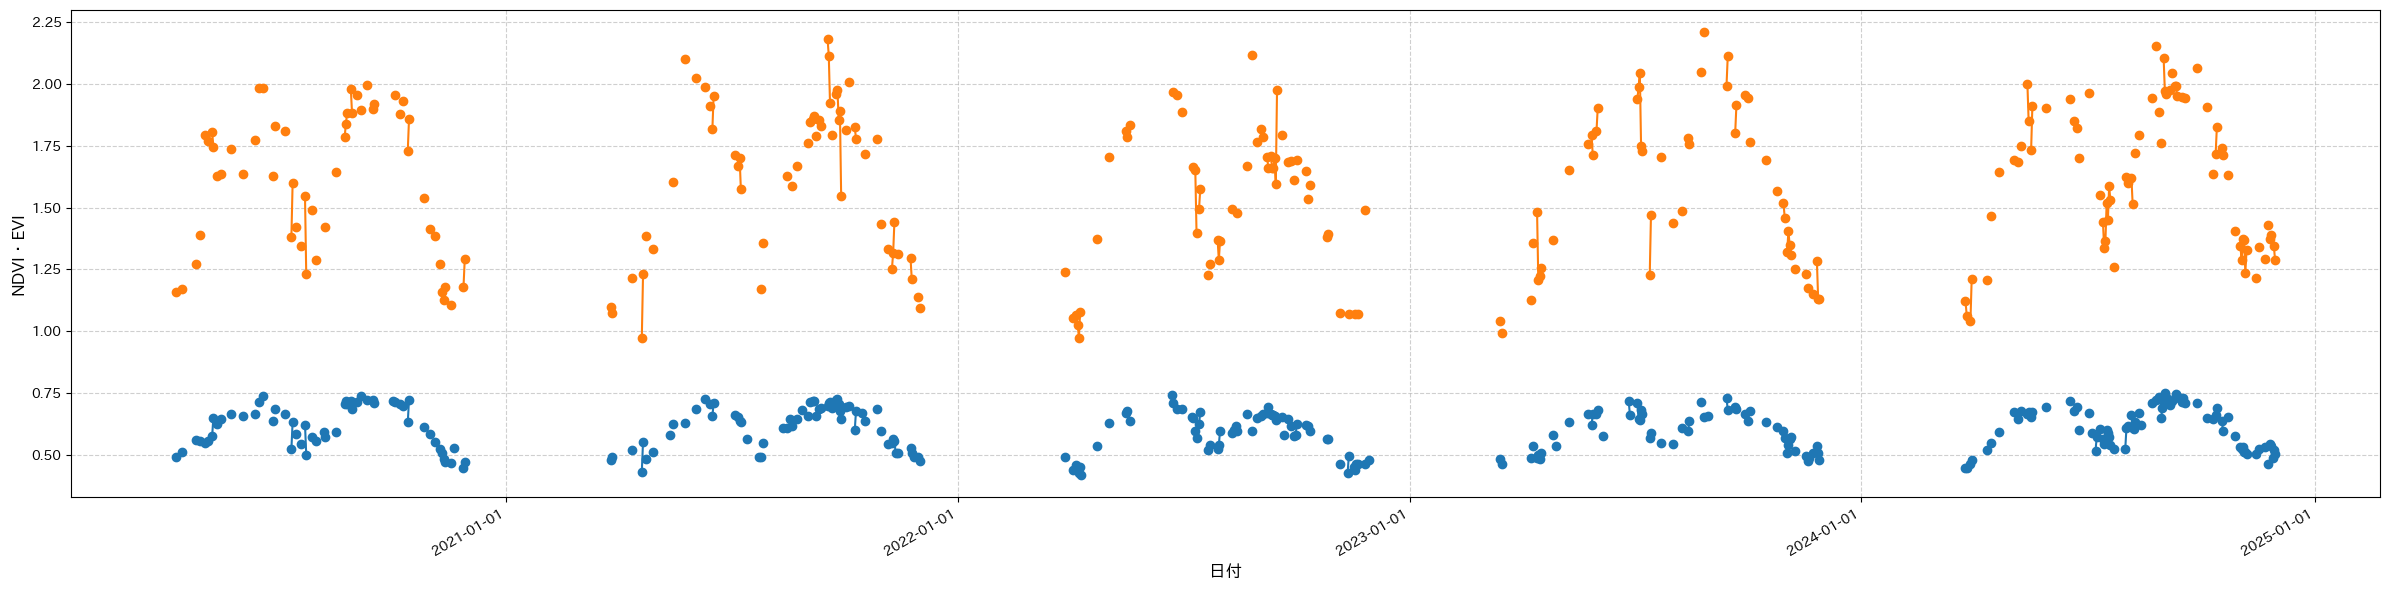

NDVIの元データ数：326
NDVIの外れ値処理後のデータ数：323
EVIの元データ数（極端な値は除去済み）：290
EVIの外れ値処理後のデータ数：285


In [45]:
df = df_vi.copy()

df['evi'] = df['evi'].where((df['evi'] >= -10) & (df['evi'] <= 10), np.nan)

threshold = 2.0  # Zスコアの閾値

# Zスコアを計算
z_scores_ndvi = (df['ndvi'] - df['ndvi'].mean()) / df['ndvi'].std()
z_scores_evi = (df['evi'] - df['evi'].mean()) / df['evi'].std()

# 閾値を超えた外れ値を特定
outliers_ndvi = z_scores_ndvi.abs() > threshold
outliers_evi = z_scores_evi.abs() > threshold

# 外れ値をNaNに置き換える
df['ndvi_cleaned'] = df['ndvi'].copy()
df['evi_cleaned'] = df['evi'].copy()
df.loc[outliers_ndvi, 'ndvi_cleaned'] = np.nan
df.loc[outliers_evi, 'evi_cleaned'] = np.nan

# グラフの作成
fig, ax = plt.subplots(figsize=(24, 6))

# datetimeオブジェクトをX軸、nanmeansをY軸としてプロット
ax.plot(df['date'], df['ndvi_cleaned'], marker='o', linestyle='-')
# ax.plot(df['date'], df['ndvi'], marker='x', linestyle='-')

ax.plot(df['date'], df['evi_cleaned'], marker='o', linestyle='-')
# ax.plot(df['date'], df['evi'], marker='x', linestyle='-')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('NDVI・EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"NDVIの元データ数：{df['ndvi'].count()}")
print(f"NDVIの外れ値処理後のデータ数：{df['ndvi_cleaned'].count()}")
print(f"EVIの元データ数（極端な値は除去済み）：{df['evi'].count()}")
print(f"EVIの外れ値処理後のデータ数：{df['evi_cleaned'].count()}")


#### 線形補間

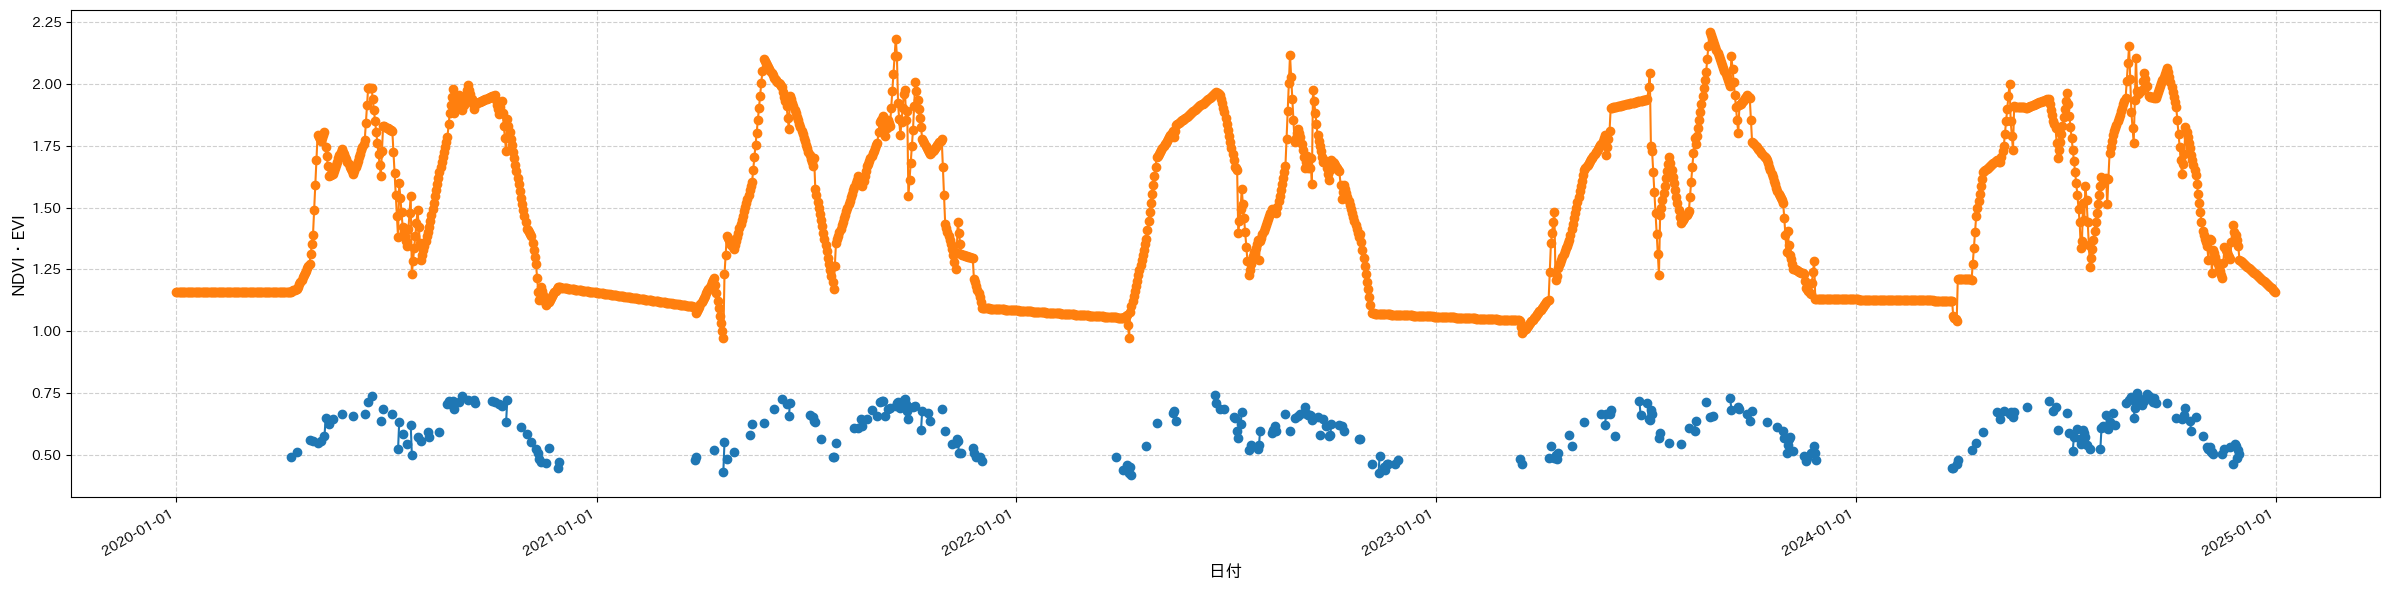

In [46]:
# 手動で値の修正
df.loc[df['date'] == pd.Timestamp('2020-11-29'), 'evi_cleaned'] = np.nan
df.loc[df['date'] == pd.Timestamp('2022-03-29'), 'evi_cleaned'] = np.nan
df.loc[df['date'] == pd.Timestamp('2022-11-26'), 'evi_cleaned'] = np.nan
df.loc[df['date'] == pd.Timestamp('2024-12-31'), 'evi_cleaned'] = 1.160178
# 線形補間
df['evi_cleaned'] = df['evi_cleaned'].interpolate(method='linear')
# 前端を最初の非NaN値で埋める
df['evi_cleaned'] = df['evi_cleaned'].bfill()

##############################

# グラフの作成
fig, ax = plt.subplots(figsize=(24, 6))

# datetimeオブジェクトをX軸、nanmeansをY軸としてプロット
ax.plot(df['date'], df['ndvi_cleaned'], marker='o', linestyle='-')
# ax.plot(df['date'], df['ndvi'], marker='x', linestyle='-')

ax.plot(df['date'], df['evi_cleaned'], marker='o', linestyle='-')
# ax.plot(df['date'], df['evi'], marker='x', linestyle='-')

# ax.set_title('NDVIの時系列変化', fontsize=16)
ax.set_xlabel('日付', fontsize=12)
ax.set_ylabel('NDVI・EVI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)

# X軸の日付フォーマットを見やすく設定
# 月と日を表示するフォーマッタ
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# ラベルが重ならないように自動で回転
fig.autofmt_xdate()

# Y軸の範囲をNDVIの典型的な値に設定（任意）
# ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


#### Savitzky-Golayフィルタ

## 目的変数と説明変数の統合

In [ ]:
# 正解データdf_respをベースにする．
df = df_resp.copy()

df = df.merge(df_degree_days, on='hanjun_start', how='left')

df.drop(['積算温度_1半旬前', '積算温度_2半旬前'], axis=1, inplace=True)

print(df)


    hanjun_start  kill_score  積算温度_3半旬前
0     2020-04-01           0  66.304770
1     2020-04-06           0  75.531730
2     2020-04-11           0  86.550977
3     2020-04-16           0  84.196312
4     2020-04-21           0  68.900737
..           ...         ...        ...
235   2024-11-06           0  49.192877
236   2024-11-11           0  47.952729
237   2024-11-16           0  48.702089
238   2024-11-21           0  45.161967
239   2024-11-26           0  53.456676

[240 rows x 3 columns]


### 冬の誘殺数を0埋めで生成（1月〜3月，12月）
★冬の体裁を整えなければならない理由は，まだ理解できていない．

冬の説明変数を取得すること自体は可能だが，今回は0埋めする．（アプローチB）

| アプローチ | 思想・目的 | モデルが学習すること | 長所 | 短所 |
| - | - | - | - | - |
| A：真の値を取得 | 「冬の環境」をありのままモデルに与える。 | ・「気温が5℃でNDVIが0.2の時は、誘殺数は0になる」という具体的な関係。<br>・冬の気象と「0」の間の強い相関。 | ・入力データが全て「真実」であるため、誠実なアプローチ。 | ・モデルが簡単な「冬=0」の予測に過剰適合し、夏の複雑な予測への学習が疎かになる恐れ（信号の希釈）。<br>・冬の各変数間の多重共線性も問題になりうる。 |
| B：0で埋める（推奨） | 「冬」という期間を「活動休止を示すベースライン=0」としてモデルに教える。 | ・「説明変数が全て0の時は、誘殺数は0になる」というシンプルなルール。<br>・説明変数が0から動き始めた時に、誘殺数がどう変化するか。 | ・モデルが「活動期」と「休止期」を明確に区別できる。<br>・各説明変数の係数が「活動期における影響度」をより純粋に表現するようになるため、モデルの解釈が容易になる。 | ・冬の期間の実際の気象データを捨てている。 |

> あなたのモデルの最終目的は、「冬の誘殺数が0であること」を当てることではなく、「夏の活動期間中の誘殺数の変動を、環境データからいかに正確に予測できるか」です。<br><br>
アプローチB（0埋め）は、モデルに対してこう伝えているのと同じです。<br>
「普段（冬）、全ての値は0です。これが平常状態です。しかし、春になり、積算温度やNDVIの値が0から増加し始めたら、注意してください。これらの値がどう動くかによって、夏の誘殺数が決まります。」<br><br>
つまり、説明変数を0埋めするのは、「冬の環境を正確に再現する」ことよりも、「モデルが夏の被害を予測するという本質的なタスクに集中できるような、理想的な入力データを作ってあげる」という目的を優先した、戦略的な判断なのです。<br><br>
これは時系列分析、特にオン/オフがはっきりしている季節性データを扱う際の、非常に一般的で効果的なテクニックです。

In [ ]:
# 1. 2020〜2024年の全ての「月半旬」の日付リストを生成
full_hanjun_dates = []
for year in range(2020, 2025):
    for month in range(1, 13): # 1月〜12月
        for day in [1, 6, 11, 16, 21, 26]:
            full_hanjun_dates.append(pd.Timestamp(year=year, month=month, day=day))

# 2. 全ての日付を持つ「テンプレート」データフレームを作成
df_template = pd.DataFrame({'hanjun_start': full_hanjun_dates})

# 3. テンプレートに元のデータを結合（'left' join）
#   -> テンプレートの日付は全て残り、元のデータにない期間（冬）はNaNになる．
df = pd.merge(df_template, df, on='hanjun_start', how='left')

# 4. 全てのNaN値を0で埋める．
df = df.fillna(0)

df['kill_score'] = df['kill_score'].astype(int)
print(df)


    hanjun_start  kill_score  積算温度_3半旬前
0     2020-01-01           0        0.0
1     2020-01-06           0        0.0
2     2020-01-11           0        0.0
3     2020-01-16           0        0.0
4     2020-01-21           0        0.0
..           ...         ...        ...
355   2024-12-06           0        0.0
356   2024-12-11           0        0.0
357   2024-12-16           0        0.0
358   2024-12-21           0        0.0
359   2024-12-26           0        0.0

[360 rows x 3 columns]


### データの正規化（スキップ）

In [ ]:
# MinMaxScalerなど？
pass


### 誘殺数の原系列を可視化

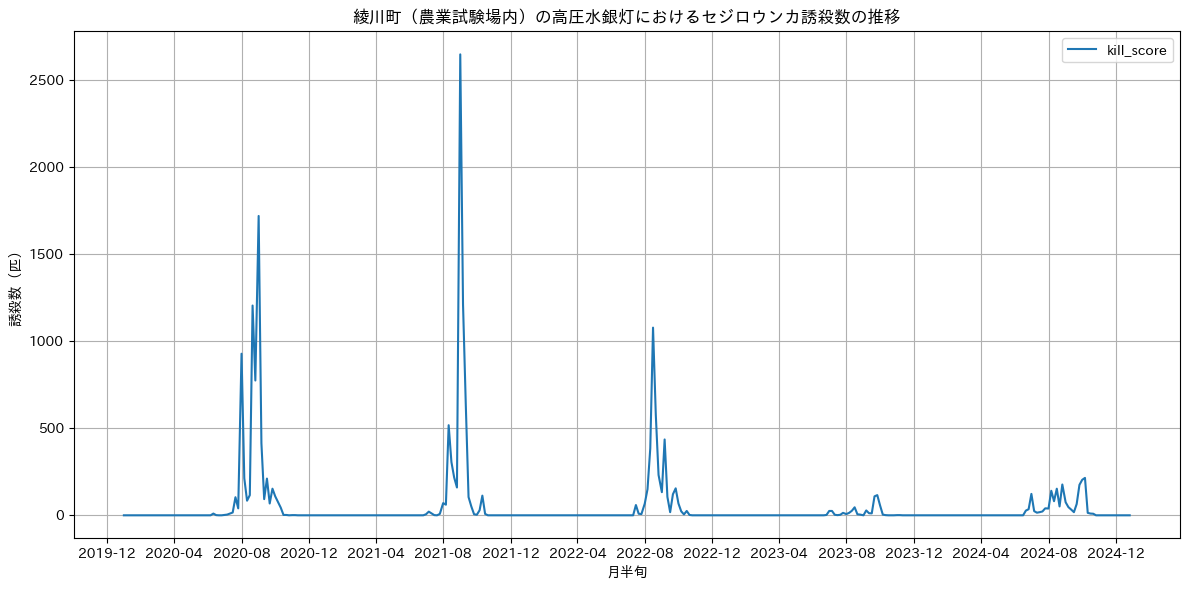

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df["hanjun_start"], df["kill_score"], label="kill_score")

# 月ごとに目盛りを表示
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # 4ヶ月ごと
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # YYYY-MM 表記

plt.title("綾川町（農業試験場内）の高圧水銀灯におけるセジロウンカ誘殺数の推移")
plt.xlabel("月半旬")
plt.ylabel("誘殺数（匹）")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# SARIMAXモデルが仮定する確率過程に誘殺数のデータが従うか確認
仮定：誘殺数 = 短期の自己相関 + 長期のトレンド + 季節効果 + * + 誤差

探索的データ解析（EDA）：データの特徴を探求し，構造を理解する作業のこと．

In [ ]:
pass

# モデルの次数決定（パラメータ最適化）
SARIMAXモデルは (p,d,q)(P,D,Q,s) というパラメータを持ちます。これを統計的な指標を基に決定します。

- (p,d,q)：非季節性のトレンドに関するパラメータ (AR, I, MA)
- (P,D,Q,s)：季節性に関するパラメータ (Seasonal AR, I, MA, Period)
- s：季節性の周期。1年間の半旬の数 365日 / 5日 = 73 より、 s=73 とします。

最適な組み合わせを見つけるために、AIC（赤池情報量規準）という指標が最も低いモデルを探すグリッドサーチを行います。

## 学習データと検証データの分離

In [ ]:
df.set_index('hanjun_start', inplace=True)

# 目的変数yと説明変数Xを定義
y = df['kill_score']
X = df[['積算温度_3半旬前']]

# 学習データ（2020-2023）
train_y = y[:'2023']
train_X = X[:'2023']
# 検証データ（2024年の活動期間）
test_y = y.loc[(y.index.year == 2024) & (y.index.month.isin(range(4, 11+1)))]
test_X = X.loc[(X.index.year == 2024) & (X.index.month.isin(range(4, 11+1)))]

print(f"学習データ期間: {train_y.index.min()} ~ {train_y.index.max()}")
print(f"テストデータ期間: {test_y.index.min()} ~ {test_y.index.max()}")


学習データ期間: 2020-01-01 00:00:00 ~ 2023-12-26 00:00:00
テストデータ期間: 2024-04-01 00:00:00 ~ 2024-11-26 00:00:00


## パラメータ推定（段階的な探索）
ブルートフォースのグリッドサーチでは遅すぎるため，段階的なパラメータの推定に変更した．

### 差分次数(d, D)を先に決定
時系列モデルは、平均が常に変動するようなトレンドを持つデータを苦手とします。そこで、差分をとることでトレンドをなくし、平均が一定のデータに変換します。

- 通常の差分 (d): 「今日の値 - 昨日の値」を計算する操作。全体的な上昇・下降トレンドを除去します。
- 季節差分 (D): 「今日の値 - 1年前の今日の値」を計算する操作。毎年繰り返される季節パターンを除去します。

これを車の運転に例えると分かりやすいです。

- 元のデータ = 車の位置（時間と共に進み続ける＝トレンドがある）
- 1次差分 (d=1) = 車の速度（一定速度で走っていれば、速度は変動しない＝定常）
- 2次差分 (d=2) = 車の加速度（速度が変化している場合に使う

次に確認すべきは、「このグラフに、まだ全体的な上昇・下降トレンドが残っているか？」です。

あなたのグラフを見る限り、データはy=0の水平線を中心に安定して推移しており、明確な上昇・下降トレンドは見当たりません。これは、季節差分を1回とるだけで、データがほぼ定常的な状態になったことを意味します。

このことから、これ以上の通常の差分は不要と判断し、**d=0**と設定するのが妥当です。

結論として、あなたのデータに最適な差分次数は d=0, D=1 と考えられます。

そして、SARIMAXモデルのAR(p)やMA(q)といった部分は、まさにこの心電図のようなギザギザの中に隠れている微かなパターン（自己相関など）を見つけ出し、モデル化するためのものです。

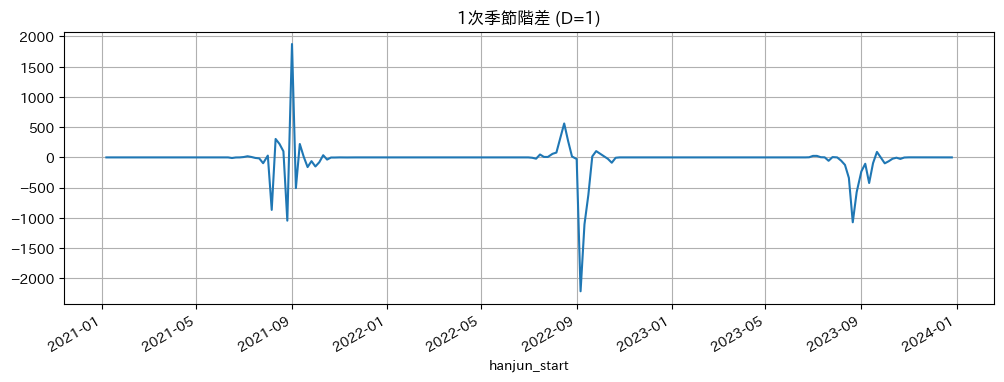

In [ ]:
# 季節差分を適用してグラフを確認
train_y.diff(73).plot(figsize=(12,4), title='1次季節階差 (D=1)')
plt.grid()
plt.show()


### 非季節性パラメータ(p, q)の探索
次に、季節性の次数をシンプルな (0,1,0,73) に固定して、非季節性のパラメータ（p, d, q）だけのグリッドサーチを行います。これにより、計算が非常に高速になります。

In [ ]:
# d=0, D=1 と仮定
d = 0
D = 1
s = 73

p = q = range(0, 3) # p,qの探索範囲を少し広げる
pdq = list(itertools.product(p, [d], q))

best_aic_pdq = np.inf
best_pdq = None

print("\n--- 非季節性の次数(p,d,q)を探索します ---")
for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(train_y,
                                        exog=train_X,
                                        order=param,
                                        seasonal_order=(0, D, 0, s), # 季節性はシンプルに固定
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit(disp=False)
        if results.aic < best_aic_pdq:
            best_aic_pdq = results.aic
            best_pdq = param
    except:
        continue

print(f'最も良い非季節性次数(p,d,q): {best_pdq} (AIC: {best_aic_pdq})')

# 最も良い非季節性次数(p,d,q): (2, 0, 2) (AIC: 2967.3686155103687)
# 最も良い非季節性次数(p,d,q): (2, 0, 2) (AIC: 2965.4182204097924)



--- 非季節性の次数(p,d,q)を探索します ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


最も良い非季節性次数(p,d,q): (2, 0, 2) (AIC: 2963.379911266745)


### 季節性パラメータ(P, Q)の探索
前ステップで見つけた最適な (p,d,q) を固定し、季節性パラメータ（P, D, Q）だけを探索します。

In [ ]:
# 前ステップで見つけたbest_pdqは固定
P = Q = range(0, 2)
seasonal_pdq_only = [(x[0], D, x[1], s) for x in list(itertools.product(P, Q))]

best_aic_seasonal = np.inf
best_seasonal_pdq = None

print("\n--- 季節性の次数(P,D,Q)を探索します ---")
for param_seasonal in seasonal_pdq_only:
    try:
        mod = sm.tsa.statespace.SARIMAX(train_y,
                                        exog=train_X,
                                        order=best_pdq, # 前ステップの結果で固定
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit(disp=False)
        if results.aic < best_aic_seasonal:
            best_aic_seasonal = results.aic
            best_seasonal_pdq = param_seasonal
    except:
        continue

print(f'最も良い季節性次数(P,D,Q,s): {best_seasonal_pdq} (AIC: {best_aic_seasonal})')

# 最も良い季節性次数(P,D,Q,s): (0, 1, 1, 73) (AIC: 1828.079270920107) <- 10分強で完了
# 最も良い季節性次数(P,D,Q,s): (0, 1, 1, 73) (AIC: 1832.054771374286) <- 11分強で完了



--- 季節性の次数(P,D,Q)を探索します ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/di

最も良い季節性次数(P,D,Q,s): (0, 1, 1, 73) (AIC: 1832.054771374286)


'\n--- 季節性の次数(P,D,Q)を探索します ---\n/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals\n  warnings.warn("Maximum Likelihood optimization failed to "\n/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.\n  warn(\'Too few observations to estimate starting parameters%s.\'\n/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals\n  warnings.warn("Maximum Likelihood optimization failed to "\n/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals\n  warnings.warn("Maximum Likelihood optimization failed to "\n/

### グリッドサーチの実行（スキップ）
ブルートフォースでは遅すぎるため，前述の段階的なパラメータの推定に変更した．

In [ ]:
"""
# パラメータの探索範囲を定義
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # 2 * 2 * 2 = 8通りの組み合わせ
seasonal_pdq = [(x[0], x[1], x[2], 73) for x in list(itertools.product(
    range(0, 2),
    range(0, 2),
    range(0, 2)
    ))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

print("\n--- 最適なSARIMAXパラメータを探索します（学習データを使用） ---")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_y,
                                            exog=train_X,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f'最も良いAIC: {best_aic}')
print(f'最も良い次数: order={best_pdq}, seasonal_order={best_seasonal_pdq}')
"""


# モデルの学習と診断
探索で見つけた最適な次数を使い、学習データで最終的なモデルを構築します。学習後、診断プロットでモデルの残差（誤差）が適切か（良いモデルの条件を満たしているか）を確認します。

## モデルの学習
- 係数coef：その説明変数が1単位増加したときに，目的変数がどれだけ増減するかを示す．絶対値が大きければ大きいほど，影響力が強い．符号は，正の相関か負の相関かを示す．
- p値：
    - 帰無仮説：「その説明変数は，目的変数に何の影響も与えない．（本当の係数は0である．）」
    - p値の意味：もし説明変数が本当は全く無関係だった場合に，今回得られたような関係性が偶然だけで観測されてしまう確率は (p * 100) % です，という意味．
    - 有意水準：0.05 (5%)
    - p < 0.05 => 統計的に有意であり，帰無仮説を棄却する．無関係ではない．
    - p >= 0.05 => 統計的に有意ではなく，帰無仮説が棄却はされない．帰無仮説が正しいと言っているわけではない事に注意．

In [ ]:
# 最適なパラメータでモデルを学習
model = sm.tsa.statespace.SARIMAX(train_y,
                                  exog=train_X,
                                  order=best_pdq,
                                  seasonal_order=best_seasonal_pdq,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)

print("\n--- モデルのサマリー ---")
print(results.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization


--- モデルのサマリー ---
                                      SARIMAX Results                                       
Dep. Variable:                           kill_score   No. Observations:                  288
Model:             SARIMAX(2, 0, 2)x(0, 1, [1], 73)   Log Likelihood                -908.027
Date:                              Wed, 17 Sep 2025   AIC                           1832.055
Time:                                      00:07:08   BIC                           1855.531
Sample:                                           0   HQIC                          1841.595
                                              - 288                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
積算温度_1半旬前     -4.4537      2.325     -1.915      0.055      -9.011       0.104
積

## モデルの保存

In [ ]:
# ファイル名を指定（拡張子は .pkl が一般的）
dt_now = dt.datetime.now(pytz.timezone('Asia/Tokyo'))
model_path = "/content/drive/MyDrive/アストロキャンプ/models/sarimax_unka_model_" + dt_now.isoformat(timespec="seconds") + ".pkl"
results.save(model_path)

print(f"学習済みモデルを '{model_path}' に保存しました．")


学習済みモデルを '/content/drive/MyDrive/アストロキャンプ/models/sarimax_unka_model_2025-09-17T09:07:08+09:00.pkl' に保存しました．


## 診断プロット
診断プロットの見方: 右下の「Correlogram」（ACFプロット）で、ラグ1以降に青い領域からはみ出す自己相関がなければ、モデルが捉えきれなかった誤差はランダムであり、良いモデルであることを示唆します。
***
- 上のグラフ（残差の時系列プロット）:
理想は、0の線を中止に、特定のパターンなく、ランダムに値が散らばっていることです。もし周期的な波や、時間と共にばらつきが広がるなどの傾向が見られたら、モデルが捉えきれていない情報が残っているサインです。

- 下のグラフ（残差の自己相関プロット）:
理想は、ラグ0（自分自身との相関なので常に1）以外に、青い信頼区間を大きくはみ出す棒がないことです。もしはみ出す棒があれば、それは誤差同士にまだ相関が残っている（＝モデルが予測に使える情報を残している）ことを意味します。

--- モデルの読み込みに成功しました ---

--- 診断プロットを生成します ---


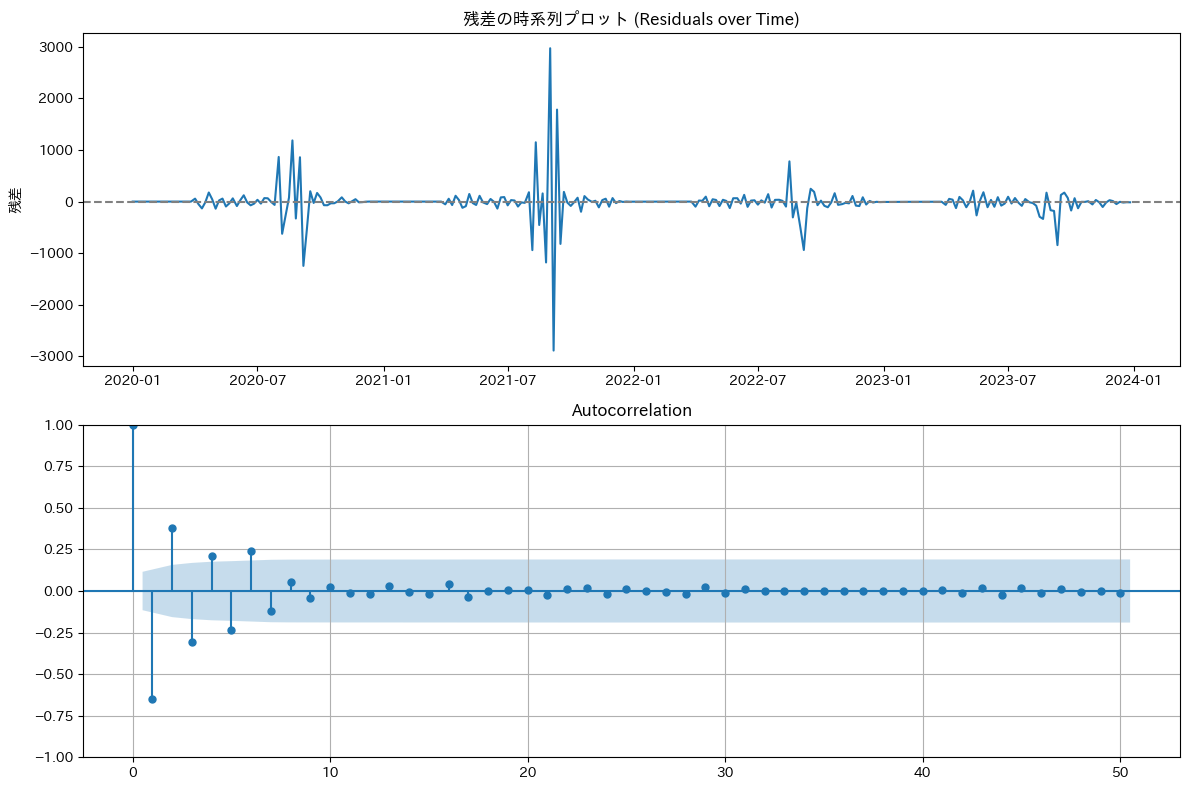

In [ ]:
model_path = "/content/drive/MyDrive/アストロキャンプ/models/sarimax_unka_model_2025-09-17T09:07:08+09:00.pkl"

# statsmodelsの専用関数でモデルをロード
try:
    loaded_results = sm.load(model_path)
    print("--- モデルの読み込みに成功しました ---")
    # print(loaded_results.summary())

    # --- 診断プロットの表示（ラグ数を減らしてエラーを回避） ---
    # lagsパラメータを追加して、診断プロットが参照するラグの数を制限
    # 季節周期(73)未満の50などに設定
    print("\n--- 診断プロットを生成します ---")

    # 自動診断ツールはデータ数が少ないため使えない模様
    """
    fig = loaded_results.plot_diagnostics(figsize=(15, 12), lags=50)
    plt.tight_layout()
    plt.show()
    """

    # --- 手動で診断プロットを作成 ---

    # 1. モデルから残差（= 実測値 - 予測値）を抽出
    residuals = loaded_results.resid

    # 描画エリアを準備
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # 2. プロット1：残差の時系列プロット
    axes[0].plot(residuals)
    axes[0].axhline(0, linestyle='--', color='gray')
    axes[0].set_title('残差の時系列プロット (Residuals over Time)')
    axes[0].set_ylabel('残差')

    # 3. プロット2：残差の自己相関（ACF）プロット
    sm.graphics.tsa.plot_acf(residuals, lags=50, ax=axes[1])

    plt.tight_layout()
    plt.grid()
    plt.show()

except FileNotFoundError:
    print(f"エラー: ファイル '{model_path}' が見つかりません。")
except Exception as e:
    print(f"モデルの読み込みまたはプロット中にエラーが発生しました: {e}")


# 予測と評価

## 未来予測の実行
loadで読み込んだモデルオブジェクト（loaded_results）を使い、テストデータ期間（例：2024年）の値を予測します。この際、その期間に対応する説明変数（test_X）も渡す必要があります。



In [ ]:
# --- 予測の実行 ---
# test_y と test_X は、事前に分割しておいた2024年のデータ

# 予測する期間のステップ数を計算（例：2024年の活動期間のデータ数）
forecast_steps = len(test_y)

# .get_forecast() を使って未来予測を生成
# stepsに予測したい期間の長さを、exogにその期間の説明変数を渡す
forecast = loaded_results.get_forecast(steps=forecast_steps, exog=test_X)

# 予測結果の平均値を取得
y_forecasted = forecast.predicted_mean.to_frame()
y_forecasted = y_forecasted.clip(lower=0) # 負の値は0へ置き換え
y_forecasted.set_index(test_X.index, inplace=True)

# 予測の信頼区間を取得
pred_ci = forecast.conf_int()
pred_ci.set_index(test_X.index, inplace=True)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## 結果の可視化と精度評価
最後に、予測値と実測値をグラフに重ねてプロットし、視覚的に精度を確認します。また、RMSE（Root Mean Squared Error）のような評価指標を計算し、予測誤差の平均的な大きさを定量的に評価します。

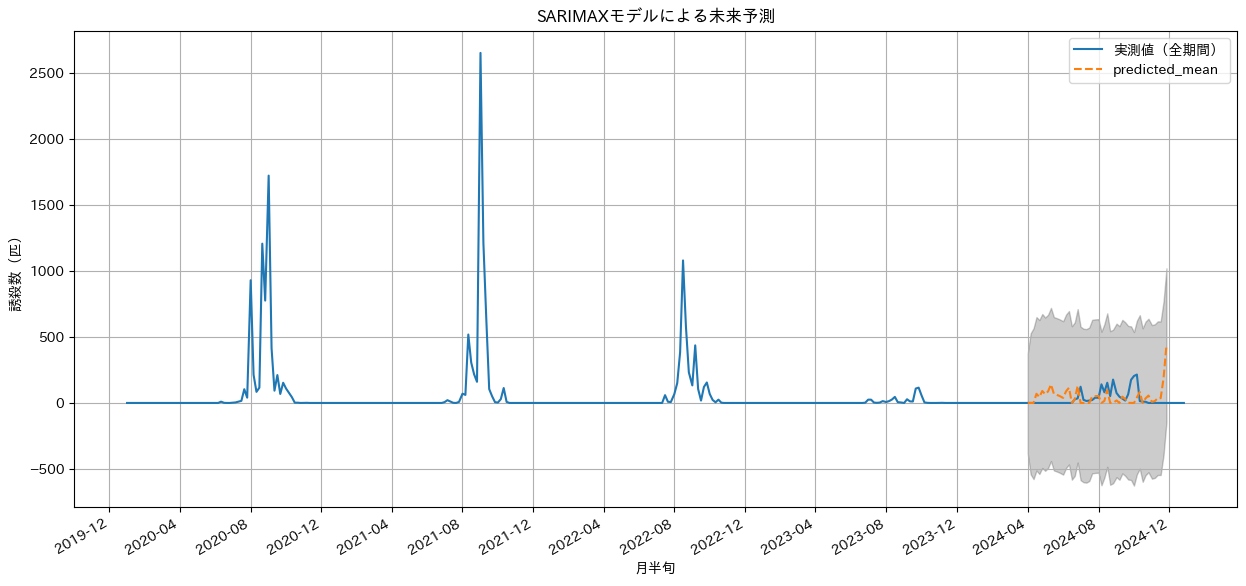


2024年活動期間におけるRMSE: 103.97


In [ ]:
# --- 予測結果の可視化 ---
plt.figure(figsize=(15, 7))
ax = y.plot(label='実測値（全期間）') # 比較のため全期間の実測値をプロット
y_forecasted.plot(ax=ax, label='未来予測値 (2024年)', style='--')

# 月ごとに目盛りを表示
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # 4ヶ月ごと
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # YYYY-MM 表記

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.title('SARIMAXモデルによる未来予測')
plt.xlabel("月半旬")
plt.ylabel("誘殺数（匹）")
plt.legend()
plt.grid()
plt.show()

# --- 精度の定量評価 ---
# 予測期間の実測値と予測値でRMSEを計算
rmse = np.sqrt(mean_squared_error(test_y, y_forecasted))
print(f'\n2024年活動期間におけるRMSE: {rmse:.2f}')


## 多重共線性の排除

### 分散拡大要因VIF


1. 係数（coef）が不安定になる：
モデルが「どの変数がどれだけ影響しているのか」を正確に分離できなくなります。例えば、「1期前の積算温度」と「2期前の積算温度」は非常に似た値を取るため、モデルはどちらの功績かを判断できず、係数が極端に大きくなったり、符号が予期せず反転したりします。

2. 係数の解釈が困難になる：
上記の理由から、係数の値を「その変数が与える純粋な影響」として信頼できなくなります。

3. p値が大きくなる（有意になりにくくなる）：
係数の推定が不安定になるため、標準誤差が大きくなります。その結果、p値が大きくなり、本当は効果があるはずの変数が「統計的に有意ではない（p > 0.05）」という誤った結論に至る可能性があります。
***
- 分散拡大要因VIF：慣例的にVIFが10を超えると、多重共線性の問題が強いと判断されます。

もしVIFが高い変数が見つかった場合は、以下のいずれかの対処法をとるのが一般的です。

1. 変数の一方を選択して削除する（最も簡単）：
相関が高い変数ペアのうち、どちらか一方をモデルから除外します。どちらを削除するかは、モデルのサマリーを見てp値がより大きい方（より効いていない方）を選ぶのが合理的です。

2. 変数を結合して新しい特徴量を作成する：
例えば、「1期前から3期前の積算温度の平均値」という新しい変数を1つだけ作り、元の3つの変数の代わりに使う。

例えば、VIFが30というのは、その説明変数の持つ情報の約97%（計算式: 1 - 1/30）が、他の説明変数によって説明できてしまう、ということを意味します。つまり、その変数はほぼ完全に他の変数と重複しており、モデルにとって新しい情報をほとんど提供できていない状態です。

In [ ]:
# 学習データの説明変数（train_X）を使ってVIFを計算
# train_X は pandas の DataFrame とします

# VIFを計算するための準備（定数項を追加）
X_with_const = sm.add_constant(train_X)

# 各変数に対してVIFを計算
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print("--- VIF（分散拡大要因）---")
# 定数項(const)のVIFは無視します
print(vif_data.iloc[1:])


--- VIF（分散拡大要因）---
     feature  VIF
1  積算温度_3半旬前  1.0


### 相関マトリクスでの単純相関

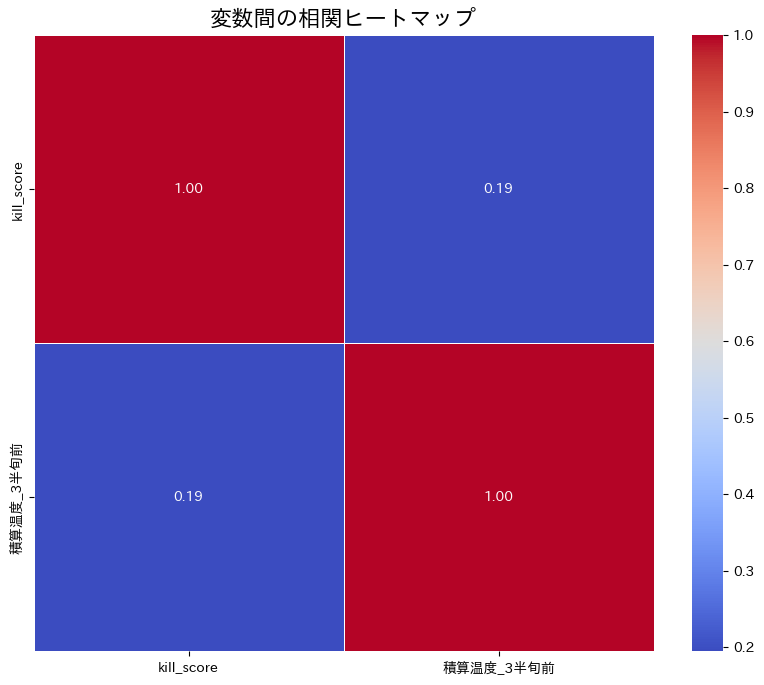

In [ ]:
plt.figure(figsize=(10, 8))

# seabornのheatmap関数を呼び出す
sns.heatmap(
    df.corr(),         # データとして相関行列を渡す
    annot=True,        # セル内に数値を表示する
    cmap='coolwarm',   # 色のマップを指定（正の相関は暖色、負の相関は寒色）
    fmt='.2f',         # 数値の書式（小数点以下2桁）
    linewidths=.5      # セル間の線の太さ
)

plt.title('変数間の相関ヒートマップ', fontsize=16)
plt.show()


## 説明変数 vs 目的変数の散布図

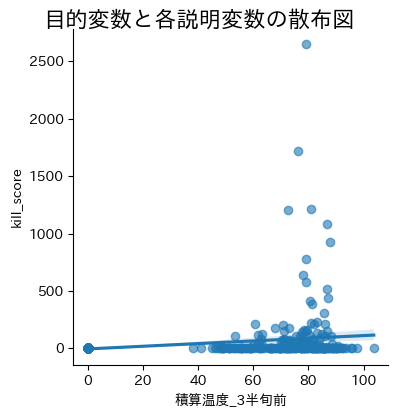

In [ ]:
# 説明変数と目的変数の列名を定義
target_variable = 'kill_score'
predictor_variables = list(X.columns)

# pairplotで散布図と回帰直線を同時に描画
# x_varsに説明変数、y_varsに目的変数を指定
sns.pairplot(
    df,
    x_vars=predictor_variables,
    y_vars=[target_variable],
    kind='reg',  # 'reg'を指定すると回帰直線が引かれる
    height=4,    # 各グラフのサイズ
    plot_kws={'scatter_kws': {'alpha': 0.6}} # 点を半透明にする
)

plt.suptitle('目的変数と各説明変数の散布図', y=1.02, size=16)
plt.show()
